Initial Disk Usage: 4.2%
Cleared /kaggle/working/train/
Cleared /kaggle/working/test/
Removed /kaggle/working/best_test_f1_model.keras
Disk Usage After Clearing: 0.0%
Free Disk Space: 19.50 GB

Checking CSV file: /kaggle/input/daataset/filtered.csv
CSV columns: ['image_id', 'image_human', 'image_path']

Sample CSV data (image_id, image_human):
               image_id                             image_human
0  929989361453621249_0              other_relevant_information
1  929989388863508480_0                        not_humanitarian
2  929989414826024960_0                        not_humanitarian
3  929989443913691136_0                  injured_or_dead_people
4  929989443913691136_1  rescue_volunteering_or_donation_effort
5  929989443913691136_2                    affected_individuals
6  929989443913691136_3                  injured_or_dead_people
7  929989459453595648_0              other_relevant_information
8  929989477828911104_0                        not_humanitarian
9  92998951456

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


954/954 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6324 - f1_score: 0.5948 - loss: 0.9543 - precision: 0.7105 - recall: 0.5200
Epoch 1
Train - Loss: 0.7848, Acc: 0.7049, Precision: 0.7638, Recall: 0.6287, F1: 0.6897
Val   - Loss: 1.2668, Acc: 0.5211, Precision: 0.5316, Recall: 0.4959, F1: 0.5132
Test  - Loss: 1.0508, Acc: 0.6356, Precision: 0.6546, Recall: 0.6116, F1: 0.6324
Saving model with improved TEST F1: 0.6324
Memory Usage: 25.4%
Disk Usage: 4.2%

Epoch 1: saving model to /kaggle/working/epoch_01_val_f1_0.5132.keras
954/954 ━━━━━━━━━━━━━━━━━━━━ 276s 207ms/step - accuracy: 0.6324 - f1_score: 0.5949 - loss: 0.9541 - precision: 0.7106 - recall: 0.5201 - val_accuracy: 0.5211 - val_f1_score: 0.5132 - val_loss: 1.2668 - val_precision: 0.5316 - val_recall: 0.4959
Epoch 2/10
954/954 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8415 - f1_score: 0.8394 - loss: 0.4299 - precision: 0.8657 - recall: 0.8146
Epoch 2
Train - Loss: 0.4270, Acc: 0.8425, Precision: 0.8638, Recall: 0.8156

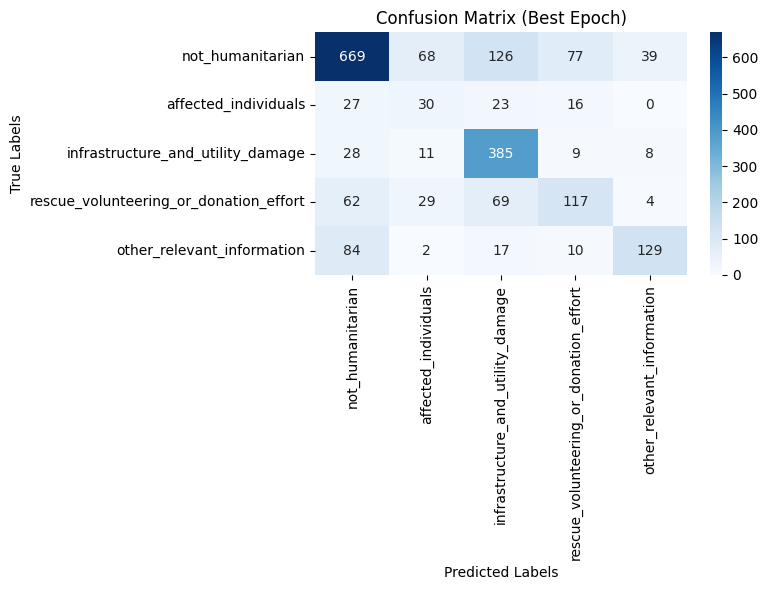

Classification Report (Best Epoch):
                                         precision    recall  f1-score   support

                      not_humanitarian     0.7690    0.6834    0.7236       979
                  affected_individuals     0.2143    0.3125    0.2542        96
     infrastructure_and_utility_damage     0.6210    0.8730    0.7257       441
rescue_volunteering_or_donation_effort     0.5109    0.4164    0.4588       281
            other_relevant_information     0.7167    0.5331    0.6114       242

                              accuracy                         0.6523      2039
                             macro avg     0.5664    0.5637    0.5548      2039
                          weighted avg     0.6691    0.6523    0.6522      2039

Sklearn Weighted F1 Score (Best Epoch): 0.6522


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import time
import glob

# Clear specific subdirectories and model files
def clear_working_directory():
    paths_to_clear = ['/kaggle/working/train/', '/kaggle/working/test/']
    for path in paths_to_clear:
        if os.path.exists(path):
            try:
                shutil.rmtree(path)
                print(f"Cleared {path}")
            except OSError as e:
                print(f"Warning: Could not clear {path}: {e}")
    model_files = glob.glob('/kaggle/working/*.keras')
    for file in model_files:
        try:
            os.remove(file)
            print(f"Removed {file}")
        except OSError as e:
            print(f"Warning: Could not remove {file}: {e}")
    os.makedirs('/kaggle/working/train/', exist_ok=True)
    os.makedirs('/kaggle/working/test/', exist_ok=True)
    print(f"Disk Usage After Clearing: {psutil.disk_usage('/kaggle/working/').percent}%")
    print(f"Free Disk Space: {psutil.disk_usage('/kaggle/working/').free / (1024**3):.2f} GB")

print(f"Initial Disk Usage: {psutil.disk_usage('/kaggle/working/').percent}%")
clear_working_directory()

# Define paths
base_dir = '/kaggle/input/inception-v3/files-20250518T181914Z-1-001/files/train/'
csv_path = '/kaggle/input/daataset/filtered.csv'
train_dir = '/kaggle/working/train/'
test_dir = '/kaggle/working/test/'
IMG_SIZE = (299, 299)
BATCH_SIZE = 16

# Define the 5 humanitarian classes
HUMANITARIAN_CLASSES = [
    'not_humanitarian',
    'affected_individuals',
    'infrastructure_and_utility_damage',
    'rescue_volunteering_or_donation_effort',
    'other_relevant_information'
]

# Verify CSV columns
print("\nChecking CSV file:", csv_path)
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}")
df = pd.read_csv(csv_path)
print("CSV columns:", df.columns.tolist())
if 'image_id' not in df.columns or 'image_human' not in df.columns:
    raise ValueError("Required columns 'image_id' and 'image_human' not found in CSV")
print("\nSample CSV data (image_id, image_human):")
print(df[['image_id', 'image_human']].head(10))
print("\nimage_human value counts:")
print(df['image_human'].value_counts())

# Debug: Inspect dataset structure
print("\nListing all files in /kaggle/input/inception-v3/:")
for root, dirs, files in os.walk('/kaggle/input/inception-v3/'):
    print(f"Directory: {root}")
    if files:
        print(f"Files: {files[:10]}")
    if dirs:
        print(f"Subdirectories: {dirs}")

# Collect image files
image_files = []
subfolders = ['srilanka_floods', 'iraq_iran_earthquake', 'Hurricane_Harvey', 'Hurricane_Maria', 
              'Hurricane_Irma', 'California_Wildfires', 'mexico_earthquake']
for subfolder in subfolders:
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.exists(subfolder_path):
        files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_files.extend(files)
        print(f"Found {len(files)} images in {subfolder_path}: {files[:5]}")
    else:
        print(f"Warning: Subfolder not found: {subfolder_path}")
print(f"\nTotal image files found: {len(image_files)}")

# Merge categories for image_human
def merge_categories(label):
    label = str(label).lower()
    if label in ['injured_or_dead_people', 'missing_or_found_people', 'affected_individuals']:
        return 'affected_individuals'
    elif label in ['vehicle_damage', 'infrastructure_and_utility_damage']:
        return 'infrastructure_and_utility_damage'
    elif label in ['not_humanitarian', 'rescue_volunteering_or_donation_effort', 'other_relevant_information']:
        return label
    else:
        return 'unknown'

df['label'] = df['image_human'].apply(merge_categories)
df = df[df['label'].isin(HUMANITARIAN_CLASSES)]
print(f"\nFiltered to {len(df)} images with valid humanitarian labels")

# Create filename variations
df['filename'] = df['image_id']
df['filename_alt1'] = df['image_id'].apply(lambda x: f"{x}.jpg")
df['filename_alt2'] = df['image_id'].apply(lambda x: f"{x}_0.jpg")
df['filename_alt3'] = df['image_id'].apply(lambda x: f"{x}_1.jpg")
df['filename_alt4'] = df['image_id'].apply(lambda x: x.split('_')[0] if '_' in x else x)
df['filename_alt5'] = df['image_id'].apply(lambda x: f"{x.split('_')[0]}.jpg" if '_' in x else f"{x}.jpg")

print("\nSample CSV data:")
print(df[['image_id', 'filename', 'filename_alt1', 'filename_alt2', 'filename_alt3', 'filename_alt4', 'filename_alt5', 'image_human', 'label']].head(10))
print(f"Total images in CSV: {len(df)}")
print("Label distribution:")
print(df['label'].value_counts())

# Debug: Print sample filenames
print("\nSample image_id values:", df['image_id'].head(10).tolist())
print("Sample available image filenames:", [os.path.basename(f) for f in image_files][:10])

# Filter CSV to existing images
available_images = set([os.path.basename(f) for f in image_files] + 
                      [os.path.splitext(os.path.basename(f))[0] for f in image_files] +
                      [os.path.basename(f).split('_')[0] for f in image_files if '_' in f] +
                      [os.path.splitext(os.path.basename(f))[0].split('_')[0] for f in image_files if '_' in f])
original_len = len(df)
df = df[df['filename'].isin(available_images) | 
        df['filename_alt1'].isin(available_images) | 
        df['filename_alt2'].isin(available_images) | 
        df['filename_alt3'].isin(available_images) |
        df['filename_alt4'].isin(available_images) |
        df['filename_alt5'].isin(available_images)]
print(f"\nFiltered CSV to {len(df)} images that exist in subfolders (from {original_len})")
if len(df) == 0:
    raise ValueError("No matching images found. Check filename consistency. Sample available images: " + str(list(available_images)[:10]))

# Create directories
for label in HUMANITARIAN_CLASSES:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f"\nTrain set size: {len(train_df)}, Test set size: {len(test_df)}")

# Copy images
train_copied = 0
test_copied = 0
for _, row in train_df.iterrows():
    src = None
    for subfolder in subfolders:
        for fname in [row['filename'], row['filename_alt1'], row['filename_alt2'], row['filename_alt3'], row['filename_alt4'], row['filename_alt5']]:
            potential_src = os.path.join(base_dir, subfolder, fname)
            if os.path.exists(potential_src):
                src = potential_src
                break
        if src:
            break
    if src:
        dest = os.path.join(train_dir, row['label'], os.path.basename(src))
        shutil.copy(src, dest)
        train_copied += 1
    else:
        print(f"Warning: Image not found for {row['filename']} or alternatives")

for _, row in test_df.iterrows():
    src = None
    for subfolder in subfolders:
        for fname in [row['filename'], row['filename_alt1'], row['filename_alt2'], row['filename_alt3'], row['filename_alt4'], row['filename_alt5']]:
            potential_src = os.path.join(base_dir, subfolder, fname)
            if os.path.exists(potential_src):
                src = potential_src
                break
        if src:
            break
    if src:
        dest = os.path.join(test_dir, row['label'], os.path.basename(src))
        shutil.copy(src, dest)
        test_copied += 1
    else:
        print(f"Warning: Image not found for {row['filename']} or alternatives")

print(f"Copied {train_copied} images to train directory")
print(f"Copied {test_copied} images to test directory")

# Count images
for label in HUMANITARIAN_CLASSES:
    num_images = len(os.listdir(os.path.join(train_dir, label)))
    print(f"Train - {label}: {num_images}")

if sum(len(os.listdir(os.path.join(train_dir, label))) for label in HUMANITARIAN_CLASSES) == 0:
    raise ValueError("No images copied to train directory.")

# Augmentation
class_counts = {label: len(os.listdir(os.path.join(train_dir, label))) for label in HUMANITARIAN_CLASSES}
max_count = max(class_counts.values())
augmentation_factors = {label: min(3, max(1, max_count // count if count > 0 else 1)) for label, count in class_counts.items()}
print("\nAugmentation factors per class:")
for label, factor in augmentation_factors.items():
    print(f"{label}: {factor} times")

datagen_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

for label in HUMANITARIAN_CLASSES:
    class_dir = os.path.join(train_dir, label)
    augmentation_factor = augmentation_factors[label]
    if augmentation_factor == 1:
        continue
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        if not os.path.exists(img_path):
            print(f"Warning: Augmented image path not found: {img_path}")
            continue
        try:
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            save_prefix = f"aug_{os.path.splitext(img_file)[0]}"
            i = 0
            for batch in datagen_aug.flow(img_array, batch_size=1, save_to_dir=class_dir, save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i >= augmentation_factor:
                    break
        except Exception as e:
            print(f"Error augmenting {img_path}: {e}")
print("Augmentation complete!")

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

def debug_generator(generator, name):
    start_time = time.time()
    for i, (images, labels) in enumerate(generator):
        if i >= 10:
            break
        print(f"{name} batch {i+1}: {images.shape}, time: {time.time() - start_time:.2f}s")
    generator.reset()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=HUMANITARIAN_CLASSES,
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=HUMANITARIAN_CLASSES,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=HUMANITARIAN_CLASSES,
    shuffle=False
)

print(f"Train generator images: {train_generator.samples}")
print(f"Validation generator images: {val_generator.samples}")
print(f"Test generator images: {test_generator.samples}")

debug_generator(train_generator, "Train")
debug_generator(val_generator, "Validation")
debug_generator(test_generator, "Test")

if train_generator.samples == 0:
    raise ValueError("Train generator found 0 images.")

# Class weights
train_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# Custom F1 Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Model Architecture
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(len(HUMANITARIAN_CLASSES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), F1Score(name='f1_score')])

# Callbacks
class BestTestF1ModelSaver(Callback):
    def __init__(self, test_data, save_path='/kaggle/working/best_test_f1_model.keras'):
        super(BestTestF1ModelSaver, self).__init__()
        self.test_data = test_data
        self.best_test_f1 = 0.0
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss', 0.0)
        train_acc = logs.get('accuracy', 0.0)
        train_precision = logs.get('precision', 0.0)
        train_recall = logs.get('recall', 0.0)
        train_f1 = logs.get('f1_score', 0.0)
        val_loss = logs.get('val_loss', 0.0)
        val_acc = logs.get('val_accuracy', 0.0)
        val_precision = logs.get('val_precision', 0.0)
        val_recall = logs.get('val_recall', 0.0)
        val_f1 = logs.get('val_f1_score', 0.0)
        test_loss, test_acc, test_precision, test_recall, test_f1 = self.model.evaluate(self.test_data, verbose=0)
        print(f"\nEpoch {epoch+1}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print(f"Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
        if test_f1 > self.best_test_f1:
            print(f"Saving model with improved TEST F1: {test_f1:.4f}")
            self.best_test_f1 = test_f1
            self.model.save(self.save_path)
        print(f"Memory Usage: {psutil.virtual_memory().percent}%")
        print(f"Disk Usage: {psutil.disk_usage('/kaggle/working/').percent}%")

checkpoint = ModelCheckpoint(
    '/kaggle/working/epoch_{epoch:02d}_val_f1_{val_f1_score:.4f}.keras',
    monitor='val_f1_score',
    save_best_only=False,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_f1_score',
    patience=3,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[BestTestF1ModelSaver(test_generator), checkpoint, early_stopping],
    verbose=1
)

# Save the final model
final_model_path = '/kaggle/working/final_model.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Verify saved model
if os.path.exists(final_model_path):
    print(f"Verified: Final model file exists at {final_model_path}")
else:
    print(f"Error: Final model file not found at {final_model_path}")

# Evaluate the best model
model = tf.keras.models.load_model(
    '/kaggle/working/best_test_f1_model.keras',
    custom_objects={'F1Score': F1Score}
)

test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_generator, verbose=1)
print(f"\nBest Epoch Test Evaluation Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

test_generator.reset()
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=HUMANITARIAN_CLASSES, yticklabels=HUMANITARIAN_CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Epoch)')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=HUMANITARIAN_CLASSES, digits=4)
print("Classification Report (Best Epoch):\n", report)

# Sklearn Weighted F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Sklearn Weighted F1 Score (Best Epoch): {f1:.4f}")